<a href="https://colab.research.google.com/github/PiriPiri57/Local-repo/blob/main/Stock_Market.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Last working day: 2025-04-28
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


First rows of stock data:
Price        Date       Close        High         Low        Open      Volume
Ticker            RELIANCE.NS RELIANCE.NS RELIANCE.NS RELIANCE.NS RELIANCE.NS
0      1996-01-01    5.834593    5.844518    5.775042    5.813325   104121369
1      1996-01-02    5.789221    5.848772    5.746685    5.820415   168743308
2      1996-01-03    5.833176    6.152199    5.820415    5.884219   209323879
3      1996-01-04    5.779295    5.796310    5.701312    5.777877   216900264
4      1996-01-05    5.739594    5.756609    5.689968    5.756609   166708467


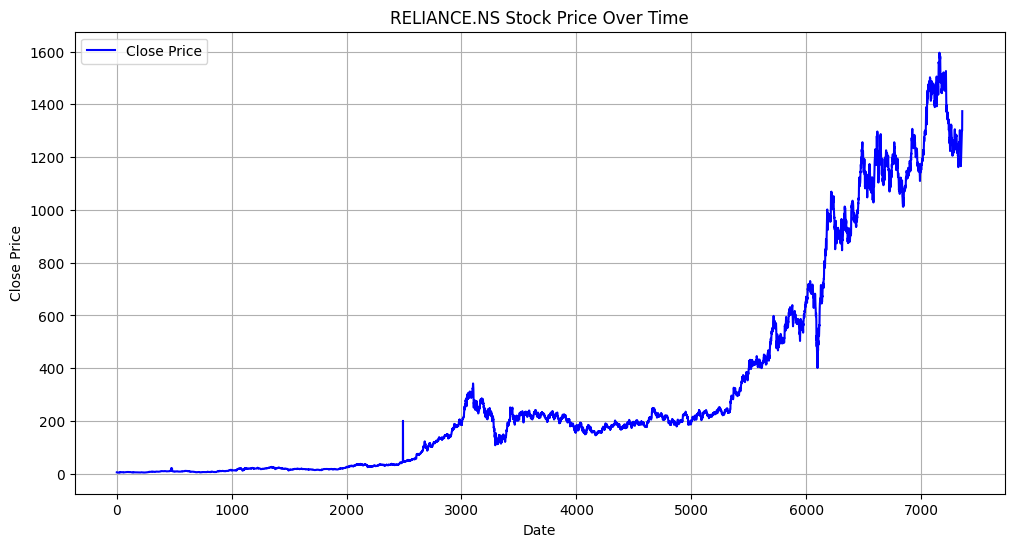

In [1]:
# Step 1: Install yfinance
!pip install yfinance --quiet
!pip install pandas_market_calendars --quiet

# Step 2: Import libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import datetime
import numpy as np
import pandas_market_calendars as mcal
import warnings
warnings.filterwarnings('ignore')
drive.mount('/content/drive')

# Step 3: Choose your stock and time period
ticker = 'RELIANCE.NS'  # You can change this to any valid stock symbol
stock = yf.Ticker(ticker)
nse = mcal.get_calendar('NSE')

# Step 4: Download historical data
today = datetime.datetime.today()

# If today is Monday (0), we need Friday's date (today - 3 days)
# If today is Sunday (6), we need Friday's date (today - 2 days)
# If today is Saturday (5), we need Friday's date (today - 1 day)
# Otherwise (Tuesday to Friday), just take yesterday

start = today - datetime.timedelta(days=10)
end = today

schedule = nse.schedule(start_date=start.strftime('%Y-%m-%d'), end_date=end.strftime('%Y-%m-%d'))
trading_days = schedule.index

# Find the last trading day before or equal to today
if today.date() in trading_days.date:
    last_working_day = today.date()
else:
    last_working_day = trading_days[trading_days < np.datetime64(today)].max().date()

print(f"Last working day: {last_working_day}")

# Step 2: Download data up to the LAST working day (INCLUDE it)
df = yf.download(ticker, end=(last_working_day + datetime.timedelta(days=1)).strftime('%Y-%m-%d'))
df.reset_index(inplace=True)

# Save entire dataset
save_path = "/content/drive/My Drive/DS_Dataset_FinanceTrends.csv"
df.to_csv(save_path, index=True)

# Step 3: Save only last working day's row into another dataset (today_features)
df_copy=df.copy()
df_full=df.copy()

# Step 5: Display first few rows
print("First rows of stock data:")
print(df.head())


# Step 6: Plot the Close price
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Close Price', color='blue')
plt.title(f"{ticker} Stock Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()


In [2]:
df.isnull().sum()

,,0
Price,Ticker,
Date,,0
Close,RELIANCE.NS,0
High,RELIANCE.NS,0
Low,RELIANCE.NS,0
Open,RELIANCE.NS,0
Volume,RELIANCE.NS,0


In [3]:
df.tail()

Price,Date,Close,High,Low,Open,Volume
Ticker,,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS
7355,2025-04-22,1291.199951,1303.900024,1286.300049,1300.000000,13051707
7356,2025-04-23,1300.000000,1306.000000,1285.400024,1297.000000,10480888
7357,2025-04-24,1301.599976,1304.500000,1290.300049,1292.400024,10468940
7358,2025-04-25,1300.400024,1325.199951,1288.099976,1303.500000,14431012
7359,2025-04-28,1374.099976,1374.599976,1320.199951,1340.000000,23354444


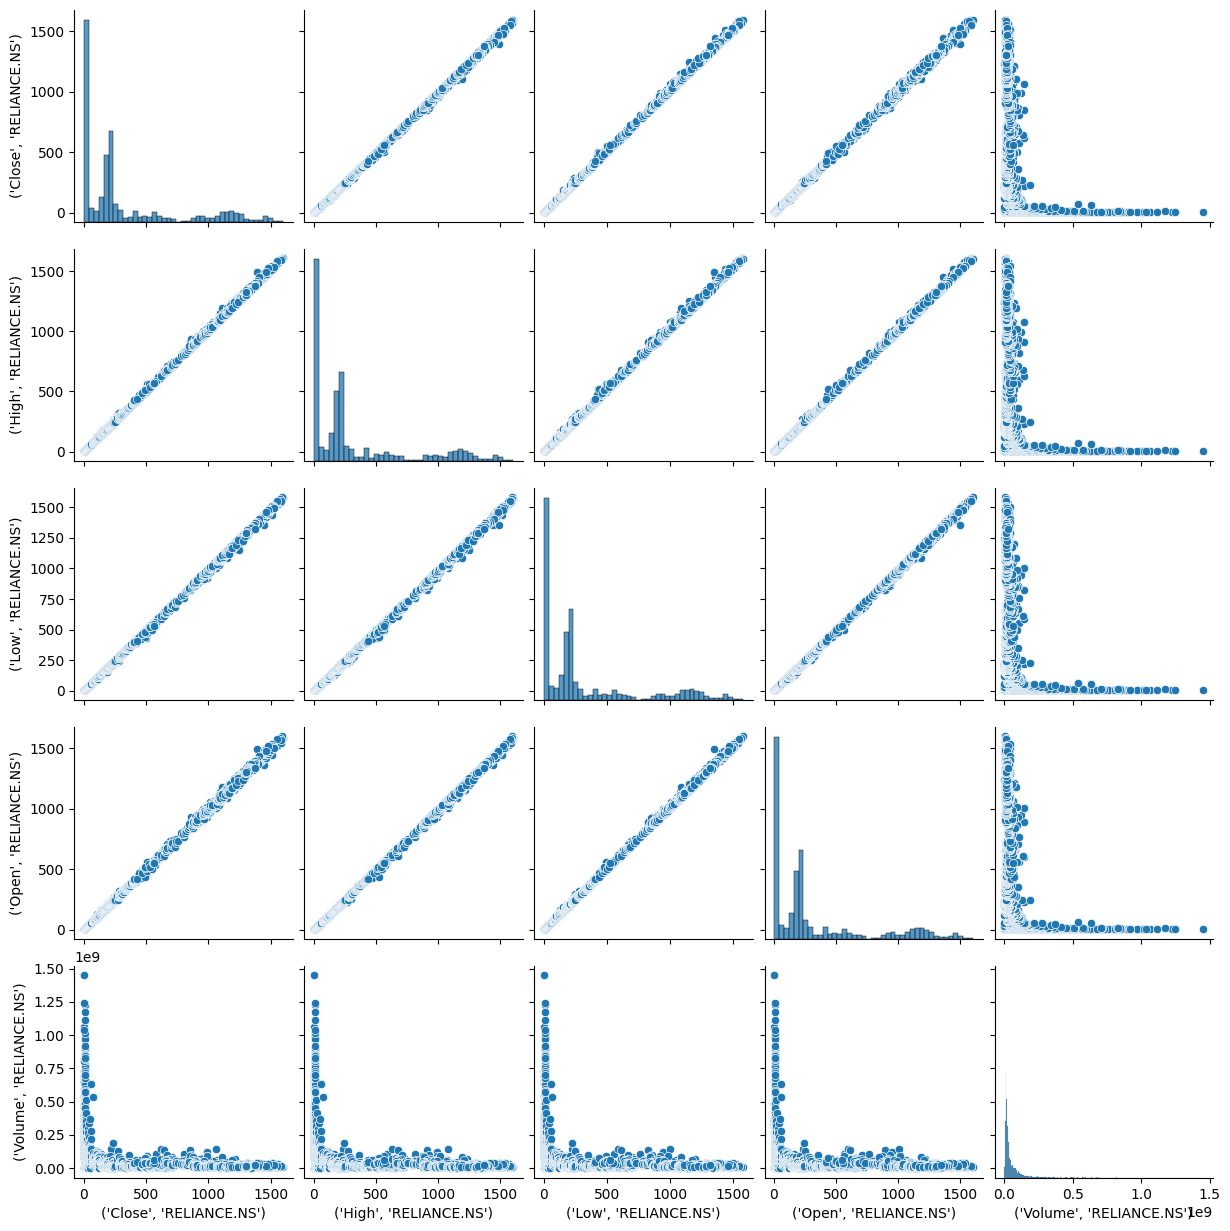

In [4]:

import seaborn as sns
import matplotlib.pyplot as plt
sns.pairplot(df)

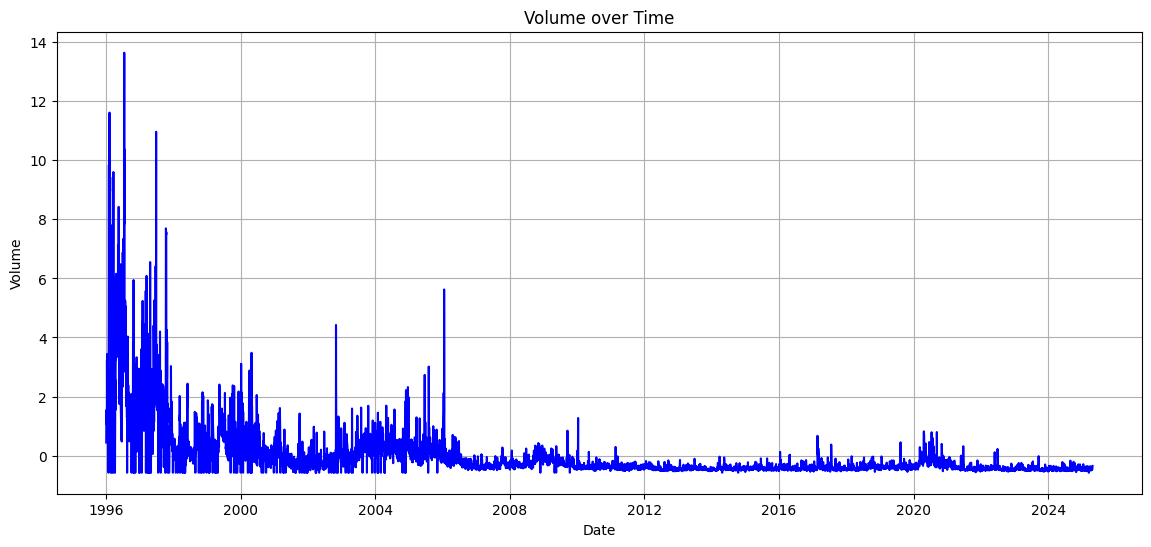

In [5]:
from sklearn.preprocessing import StandardScaler
df['Date'] = pd.to_datetime(df['Date'])
scaler = StandardScaler()
df['Volume_scaled'] = scaler.fit_transform(df[['Volume']])

plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['Volume_scaled'], color='blue')
plt.title('Volume over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid(True)
plt.show()

In [6]:
df.drop(columns=['Dividends', 'Stock Splits'], inplace=True, errors='ignore') #Removing constant columns


df.head()

Price,Date,Close,High,Low,Open,Volume,Volume_scaled
Ticker,,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,
0,1996-01-01,5.834593,5.844518,5.775042,5.813325,104121369,0.441402
1,1996-01-02,5.789221,5.848772,5.746685,5.820415,168743308,1.075882
2,1996-01-03,5.833176,6.152199,5.820415,5.884219,209323879,1.474315
3,1996-01-04,5.779295,5.796310,5.701312,5.777877,216900264,1.548703
4,1996-01-05,5.739594,5.756609,5.689968,5.756609,166708467,1.055903


In [7]:
import numpy as np
# --- 1. Date Parts ---
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['IsMonthStart'] = df['Date'].dt.is_month_start.astype(int)
df['IsMonthEnd'] = df['Date'].dt.is_month_end.astype(int)

# --- 2. Lag Features ---
df['lag_1'] = df['Close'].shift(1)  # yesterday's close
df['lag_5'] = df['Close'].shift(5)  # close 5 days ago
df['lag_10'] = df['Close'].shift(10)

# --- 3. Rolling Means ---
df['rolling_mean_5'] = df['Close'].rolling(window=5).mean()
df['rolling_mean_10'] = df['Close'].rolling(window=10).mean()
df['rolling_mean_20'] = df['Close'].rolling(window=20).mean()


# --- 4. Returns ---
df['Daily_Return'] = df['Close'].pct_change()
df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))

df['Log_Volume'] = df['Volume'].shift(1)
df['Rolling_Volume'] = df['Volume'].rolling(3).mean()


# --- Drop NaNs caused by shift/rolling ---
df.dropna(inplace=True)

In [8]:
df_raw=df.copy()
df.drop(columns=['Date'], inplace=True, errors='ignore')  #removing categorical columns, doesnt has any significant affect on data no point of encoding it
df.head()

Price,Close,High,Low,Open,Volume,Volume_scaled,Year,Month,Day,DayOfWeek,...,lag_1,lag_5,lag_10,rolling_mean_5,rolling_mean_10,rolling_mean_20,Daily_Return,Log_Return,Log_Volume,Rolling_Volume
Ticker,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,,,,,,...,,,,,,,,,,
19,4.358575,4.358575,4.358575,4.358575,0,-0.580896,1996,1,26,4,...,4.358575,4.837820,5.319901,4.579765,4.826477,5.200586,0.000000,0.000000,3.608558e+08,2.373472e+08
20,4.701703,4.742822,4.311785,4.338724,652902286,5.829515,1996,1,29,0,...,4.358575,4.920057,5.264603,4.536094,4.770187,5.143941,0.078725,0.075779,0.000000e+00,3.379194e+08
21,5.124233,5.359602,4.778270,4.849163,1061936020,9.845544,1996,1,30,1,...,4.701703,4.711629,5.274528,4.618615,4.755158,5.110692,0.089868,0.086056,6.529023e+08,5.716128e+08
22,5.012220,5.267439,4.884610,5.076025,731560842,6.601811,1996,1,31,2,...,5.124233,4.549990,5.064682,4.711061,4.749911,5.069644,-0.021860,-0.022102,1.061936e+09,8.154664e+08
23,5.213560,5.246171,4.948416,4.962594,640422958,5.706989,1996,2,1,3,...,5.012220,4.358575,4.924311,4.882058,4.778836,5.041357,0.040170,0.039384,7.315608e+08,8.113066e+08


In [9]:
df.head(8)

Price,Close,High,Low,Open,Volume,Volume_scaled,Year,Month,Day,DayOfWeek,...,lag_1,lag_5,lag_10,rolling_mean_5,rolling_mean_10,rolling_mean_20,Daily_Return,Log_Return,Log_Volume,Rolling_Volume
Ticker,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,,,,,,...,,,,,,,,,,
19,4.358575,4.358575,4.358575,4.358575,0,-0.580896,1996,1,26,4,...,4.358575,4.837820,5.319901,4.579765,4.826477,5.200586,0.000000,0.000000,3.608558e+08,2.373472e+08
20,4.701703,4.742822,4.311785,4.338724,652902286,5.829515,1996,1,29,0,...,4.358575,4.920057,5.264603,4.536094,4.770187,5.143941,0.078725,0.075779,0.000000e+00,3.379194e+08
21,5.124233,5.359602,4.778270,4.849163,1061936020,9.845544,1996,1,30,1,...,4.701703,4.711629,5.274528,4.618615,4.755158,5.110692,0.089868,0.086056,6.529023e+08,5.716128e+08
22,5.012220,5.267439,4.884610,5.076025,731560842,6.601811,1996,1,31,2,...,5.124233,4.549990,5.064682,4.711061,4.749911,5.069644,-0.021860,-0.022102,1.061936e+09,8.154664e+08
23,5.213560,5.246171,4.948416,4.962594,640422958,5.706989,1996,2,1,3,...,5.012220,4.358575,4.924311,4.882058,4.778836,5.041357,0.040170,0.039384,7.315608e+08,8.113066e+08
24,5.779295,5.841682,5.352512,5.352512,818725675,7.457625,1996,2,2,4,...,5.213560,4.358575,4.837820,5.166202,4.872984,5.043342,0.108512,0.103019,6.404230e+08,7.302365e+08
25,6.259958,6.386150,5.913995,6.096901,1222482548,11.421843,1996,2,5,0,...,5.779295,4.701703,4.920057,5.477853,5.006974,5.080845,0.083170,0.079892,8.187257e+08,8.938771e+08
26,5.735341,6.522267,5.603478,6.410254,1242315590,11.616571,1996,2,6,1,...,6.259958,5.124233,4.711629,5.600075,5.109345,5.100058,-0.083805,-0.087526,1.222483e+09,1.094508e+09


<Axes: xlabel='Price-Ticker', ylabel='Price-Ticker'>

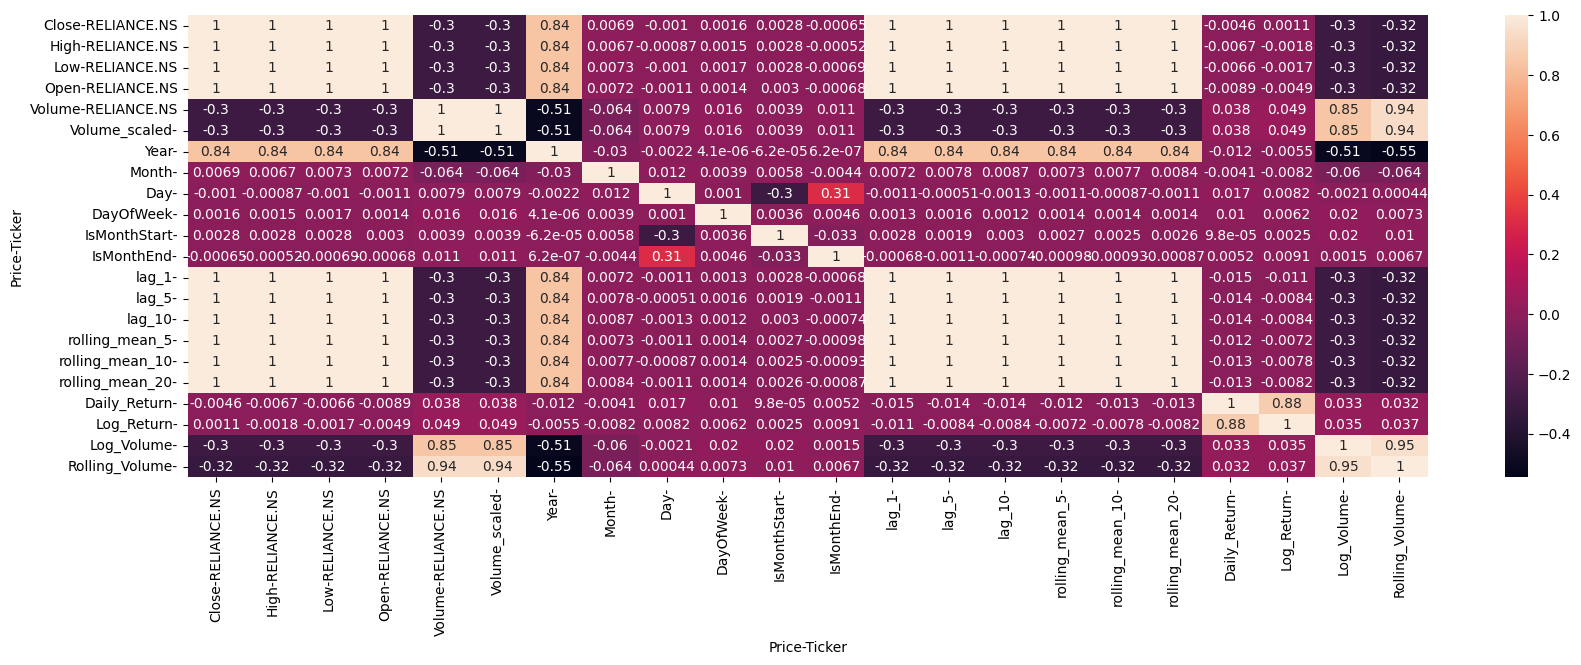

In [10]:

plt.figure(figsize=(20, 6))
sns.heatmap(data=df.corr(),annot=True)

In [11]:
df.drop(columns=['lag_5','lag_10','Open','Low','Rolling_Volume','Daily_Return','IsMonthStart','rolling_mean_10','rolling_mean_20'], inplace=True, errors='ignore')   #we are dropping the columns which are higly correlated to avoid overfitting
df.head()

Price,Close,High,Volume,Volume_scaled,Year,Month,Day,DayOfWeek,IsMonthEnd,lag_1,rolling_mean_5,Log_Return,Log_Volume
Ticker,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,,,,,,,,,,
19,4.358575,4.358575,0,-0.580896,1996,1,26,4,0,4.358575,4.579765,0.000000,3.608558e+08
20,4.701703,4.742822,652902286,5.829515,1996,1,29,0,0,4.358575,4.536094,0.075779,0.000000e+00
21,5.124233,5.359602,1061936020,9.845544,1996,1,30,1,0,4.701703,4.618615,0.086056,6.529023e+08
22,5.012220,5.267439,731560842,6.601811,1996,1,31,2,1,5.124233,4.711061,-0.022102,1.061936e+09
23,5.213560,5.246171,640422958,5.706989,1996,2,1,3,0,5.012220,4.882058,0.039384,7.315608e+08


<Axes: xlabel='Price-Ticker', ylabel='Price-Ticker'>

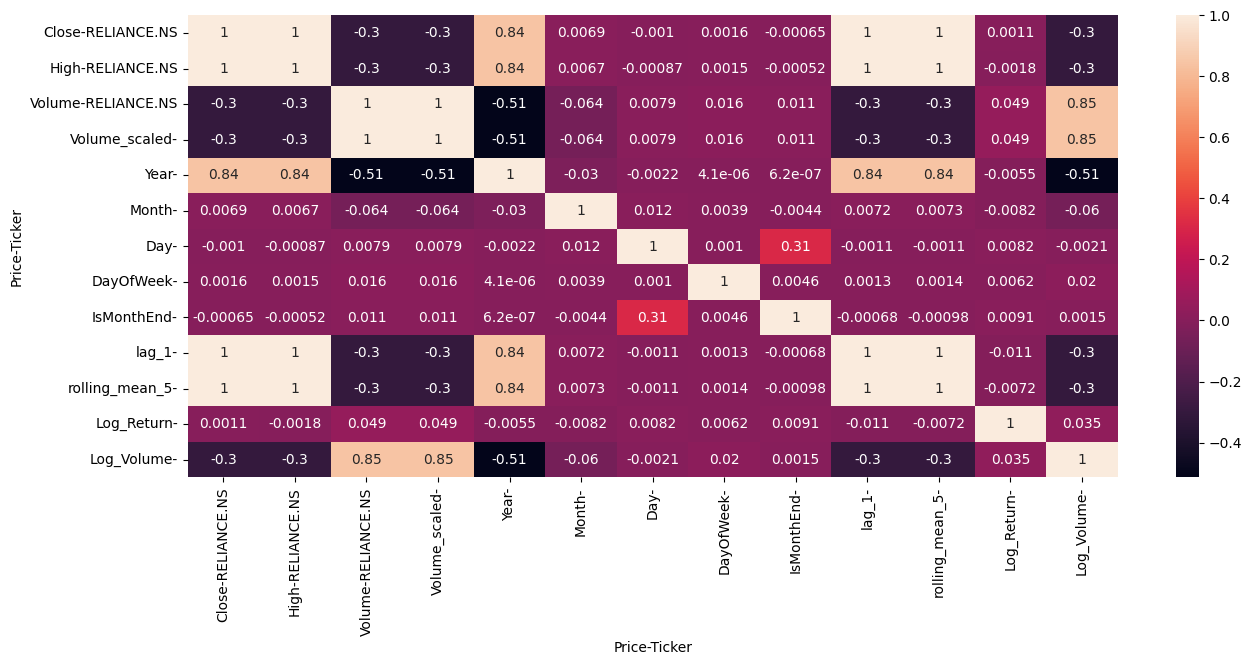

In [12]:
plt.figure(figsize=(15, 6))
sns.heatmap(data=df.corr(),annot=True)

In [13]:
from sklearn.preprocessing import StandardScaler

import seaborn as sns
scaler = StandardScaler()
df[['High', 'Close', 'Volume', 'lag_1', 'rolling_mean_5', 'Log_Return']] = scaler.fit_transform(df[['High', 'Close', 'Volume', 'lag_1', 'rolling_mean_5', 'Log_Return']])
df.head()



Price,Close,High,Volume,Volume_scaled,Year,Month,Day,DayOfWeek,IsMonthEnd,lag_1,rolling_mean_5,Log_Return,Log_Volume
Ticker,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,,,,,,,,,,
19,-0.791317,-0.792903,-0.578663,-0.580896,1996,1,26,4,0,-0.791182,-0.790618,-0.022697,3.608558e+08
20,-0.790473,-0.791968,5.869507,5.829515,1996,1,29,0,0,-0.791182,-0.790725,2.171906,0.000000e+00
21,-0.789434,-0.790466,9.909191,9.845544,1996,1,30,1,0,-0.790338,-0.790522,2.469525,6.529023e+08
22,-0.789709,-0.790690,6.646352,6.601811,1996,1,31,2,1,-0.789299,-0.790295,-0.662780,1.061936e+09
23,-0.789214,-0.790742,5.746259,5.706989,1996,2,1,3,0,-0.789574,-0.789874,1.117877,7.315608e+08


In [14]:
df["Close"].describe()

Ticker,RELIANCE.NS
count,7341.000000
mean,0.000000
std,1.000068
min,-0.791317
25%,-0.748952
50%,-0.335675
75%,0.203450
max,3.121305


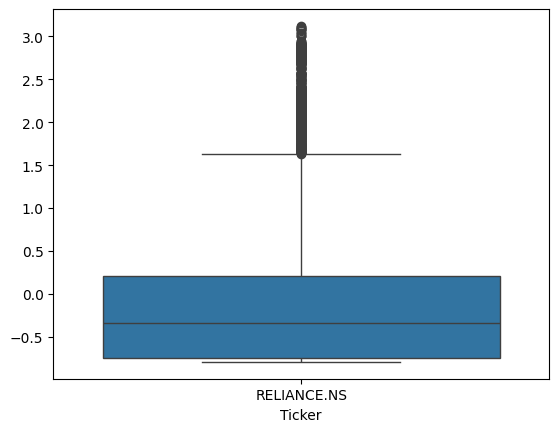

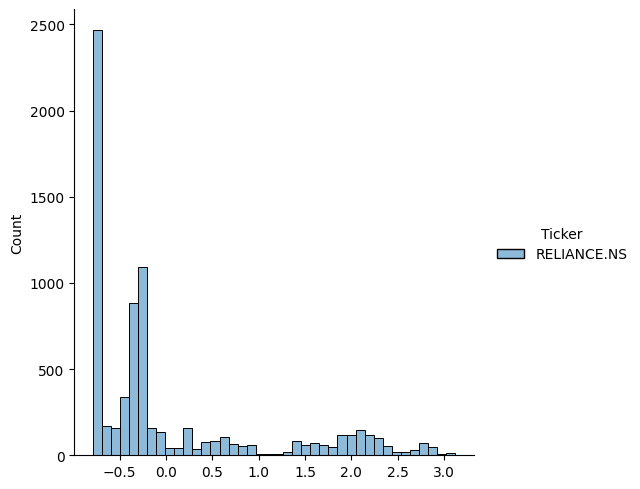

In [15]:
sns.boxplot(df['Close'])                              #Checking for outliers cause for stock market outliers indicate trend breakers
sns.displot(df['Close'])
plt.show()

In [16]:
today_data=df_raw.iloc[-1]
df=df.iloc[:-1]
df.describe()

Price,Close,High,Volume,Volume_scaled,Year,Month,Day,DayOfWeek,IsMonthEnd,lag_1,rolling_mean_5,Log_Return,Log_Volume
Ticker,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,,,,,,,,,,
count,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7340.000000,7.340000e+03
mean,-0.000351,-0.000347,0.000047,-0.005574,2010.018256,6.489101,15.763760,1.997820,0.033515,-0.000327,-0.000331,-0.000214,5.864389e+07
std,0.999684,0.999695,1.000128,0.994271,8.485567,3.447505,8.786722,1.413634,0.179989,0.999745,0.999734,0.999967,1.013270e+08
min,-0.791317,-0.792903,-0.578663,-0.580896,1996.000000,1.000000,1.000000,0.000000,0.000000,-0.791182,-0.790725,-42.578170,0.000000e+00
25%,-0.748954,-0.750042,-0.444453,-0.447471,2003.000000,3.000000,8.000000,1.000000,0.000000,-0.748815,-0.749013,-0.329637,1.358934e+07
50%,-0.335720,-0.335277,-0.342001,-0.345619,2010.000000,6.500000,16.000000,2.000000,0.000000,-0.335508,-0.334831,-0.015041,2.397078e+07
75%,0.202947,0.202076,0.026728,0.020950,2017.000000,9.000000,23.000000,3.000000,0.000000,0.202945,0.204795,0.308997,6.131746e+07
max,3.121305,3.100344,13.730803,13.644777,2025.000000,12.000000,31.000000,6.000000,1.000000,3.123043,3.099715,42.718658,1.448889e+09


In [17]:
import warnings
warnings.filterwarnings('ignore')
today_data_df = pd.DataFrame([today_data])
today_data_df.drop(columns=['Date','lag_5','lag_10','Open','Low','Rolling_Volume','Daily_Return','IsMonthStart','rolling_mean_10','rolling_mean_20'], inplace=True, errors='ignore')
today_data_df.describe()

Price,Close,High,Volume,Volume_scaled,Year,Month,Day,DayOfWeek,IsMonthEnd,lag_1,rolling_mean_5,Log_Return,Log_Volume
Ticker,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,,,,,,,,,,
count,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.0
mean,1374.099976,1374.599976,23354444.0,-0.351594,2025.0,4.0,28.0,0.0,0.0,1300.400024,1313.459985,0.055127,14431012.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1374.099976,1374.599976,23354444.0,-0.351594,2025.0,4.0,28.0,0.0,0.0,1300.400024,1313.459985,0.055127,14431012.0
25%,1374.099976,1374.599976,23354444.0,-0.351594,2025.0,4.0,28.0,0.0,0.0,1300.400024,1313.459985,0.055127,14431012.0
50%,1374.099976,1374.599976,23354444.0,-0.351594,2025.0,4.0,28.0,0.0,0.0,1300.400024,1313.459985,0.055127,14431012.0
75%,1374.099976,1374.599976,23354444.0,-0.351594,2025.0,4.0,28.0,0.0,0.0,1300.400024,1313.459985,0.055127,14431012.0
max,1374.099976,1374.599976,23354444.0,-0.351594,2025.0,4.0,28.0,0.0,0.0,1300.400024,1313.459985,0.055127,14431012.0


In [18]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')
# --- 1. Prepare Data ---

# Define X and y
X = df.drop(['Close'], axis=1)  # Drop target
y = df['Close']

# Sort the data by date (Ensure your data is sorted by date/time)
df = df.sort_index()  # Assuming your dataframe is indexed by date

# Split into train and test (chronologically)
train_size = int(len(df) * 0.8)  # 80% training data
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# --- 2. Define Models ---

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
}

# --- 3. Train and Evaluate ---

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        'MAE': mae,
        'RMSE': rmse,
        'R² Score': r2
    }

# --- 4. Display Results ---
results_df = pd.DataFrame(results).T
print(results_df)


                        MAE      RMSE  R² Score
Linear Regression  0.020162  0.026157  0.998373
Ridge Regression   0.020590  0.027129  0.998250
Lasso Regression   0.686642  0.715105 -0.216133
Random Forest      1.081550  1.244448 -2.682940
Decision Tree      1.074857  1.237688 -2.643036
Gradient Boosting  1.079147  1.242277 -2.670101
XGBoost            1.104180  1.264734 -2.803992


Best Model Selected: Linear Regression


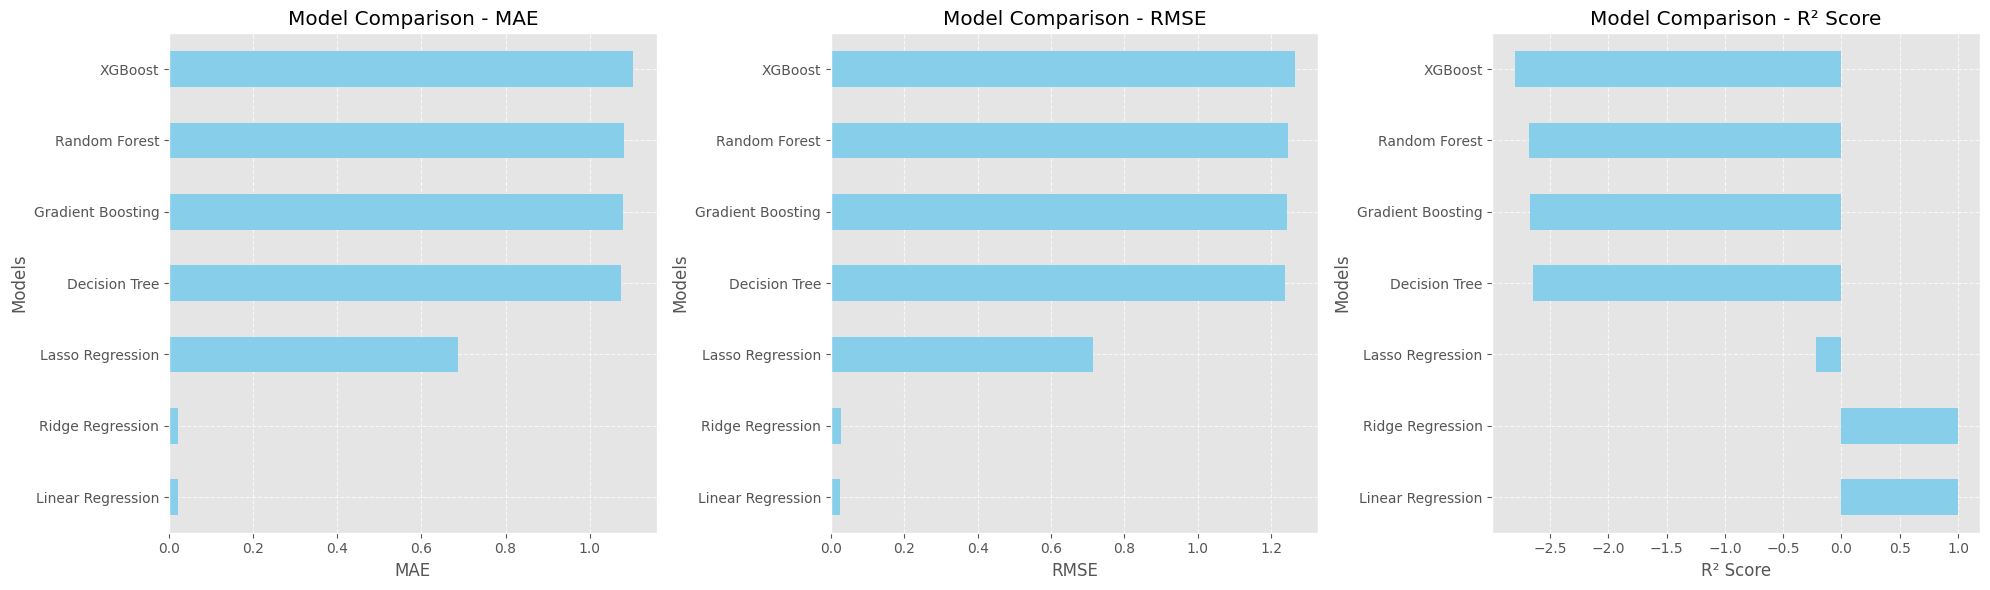

In [19]:
best_model_name = results_df['R² Score'].idxmax()
best_model = models[best_model_name]

print(f"Best Model Selected: {best_model_name}")

import matplotlib.pyplot as plt

# Use a default style
plt.style.use('ggplot')  # or 'default', 'bmh', etc.

# Metrics you want to plot
metrics = ['MAE', 'RMSE', 'R² Score']

# Create a figure with 3 subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(20, 6))  # Width=20, Height=6

# Loop through each metric and corresponding axis
for idx, metric in enumerate(metrics):
    ax = axes[idx]
    sorted_data = results_df[metric].sort_values(ascending=True if metric != 'R² Score' else False)
    sorted_data.plot(kind='barh', ax=ax, color='skyblue')
    ax.set_title(f'Model Comparison - {metric}')
    ax.set_xlabel(metric)
    ax.set_ylabel('Models')
    ax.grid(True, linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()
plt.show()




# From the above plot we infer that Ridge and Linear Regression are the best fit

In [20]:
# --- Prepare today's data properly ---

# Step 1: Convert today_data to a DataFrame

##########################################
# Step 5: Fill any NaNs
today_data_df.fillna(0, inplace=True)
X=df.drop(['Close'], axis=1)
feature_names = X.columns

# Step 2: Keep only the columns you trained on
today_data_df = today_data_df[feature_names]

# Step 3: Now safely scale
today_data_scaled = scaler.transform(today_data_df)

# Step 7: Predict today's close
today_prediction = best_model.predict(today_data_df)
predicted_close = today_prediction.flatten()[0]

# Step 8: Get actual close
actual_close = today_data['Close'].item()

# Step 9: Calculate accuracy
accuracy = (1 - abs(actual_close - predicted_close) / actual_close) * 100

# Step 10: Display prediction
print("Today's Close Prediction Results")
print(f"Predicted Close Value ({best_model_name}): {predicted_close:.2f}")
print(f"Actual Close Value: {actual_close:.2f}")
print(f"Prediction Accuracy: {accuracy:.2f}%")


Today's Close Prediction Results
Predicted Close Value (Linear Regression): 1003.16
Actual Close Value: 1374.10
Prediction Accuracy: 73.01%


In [21]:
df.head()

Price,Close,High,Volume,Volume_scaled,Year,Month,Day,DayOfWeek,IsMonthEnd,lag_1,rolling_mean_5,Log_Return,Log_Volume
Ticker,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,,,,,,,,,,
19,-0.791317,-0.792903,-0.578663,-0.580896,1996,1,26,4,0,-0.791182,-0.790618,-0.022697,3.608558e+08
20,-0.790473,-0.791968,5.869507,5.829515,1996,1,29,0,0,-0.791182,-0.790725,2.171906,0.000000e+00
21,-0.789434,-0.790466,9.909191,9.845544,1996,1,30,1,0,-0.790338,-0.790522,2.469525,6.529023e+08
22,-0.789709,-0.790690,6.646352,6.601811,1996,1,31,2,1,-0.789299,-0.790295,-0.662780,1.061936e+09
23,-0.789214,-0.790742,5.746259,5.706989,1996,2,1,3,0,-0.789574,-0.789874,1.117877,7.315608e+08


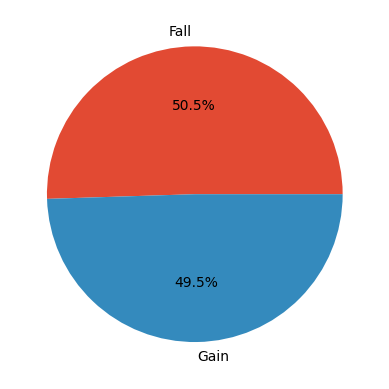

In [22]:
df['Gain/Fall'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)
df.tail()

plt.pie(df['Gain/Fall'].value_counts().values,
        labels=["Fall", "Gain"], autopct='%1.1f%%')
plt.show()

# Step 1: Features and Target for classification
X_cls = df.drop(['Close', 'Gain/Fall'], axis=1)  # Use all features except Close and Gain/Fall make it greeej
y_cls = df['Gain/Fall']                          # Target is Gain/Fall

# Train-Test Split
train_size_cls = int(len(df) * 0.8)
X_train_cls, X_test_cls = X_cls.iloc[:train_size_cls], X_cls.iloc[train_size_cls:]
y_train_cls, y_test_cls = y_cls.iloc[:train_size_cls], y_cls.iloc[train_size_cls:]

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
models = [LogisticRegression(),
  XGBClassifier(),
  RandomForestClassifier(n_estimators=100, random_state=42),
  DecisionTreeClassifier(random_state=42),
  KNeighborsClassifier(n_neighbors=5),
  GradientBoostingClassifier(n_estimators=100, random_state=42)]

for i in range(6):
  models[i].fit(X_train_cls, y_train_cls)

  print(f'{models[i].__class__.__name__} : ')
  print('Training Accuracy : ', metrics.roc_auc_score(
    y_train_cls, models[i].predict_proba(X_train_cls)[:,1]))
  print('Validation Accuracy : ', metrics.roc_auc_score(
    y_test_cls, models[i].predict_proba(X_test_cls)[:,1]))
  print()



LogisticRegression : 
Training Accuracy :  0.5055661505839241
Validation Accuracy :  0.4891281731169372

XGBClassifier : 
Training Accuracy :  0.990800906417277
Validation Accuracy :  0.5129191189584448

RandomForestClassifier : 
Training Accuracy :  1.0
Validation Accuracy :  0.4686617546519232

DecisionTreeClassifier : 
Training Accuracy :  1.0
Validation Accuracy :  0.49503968253968256

KNeighborsClassifier : 
Training Accuracy :  0.7591310241185745
Validation Accuracy :  0.491748595505618

GradientBoostingClassifier : 
Training Accuracy :  0.7420239815653853
Validation Accuracy :  0.473979697996552



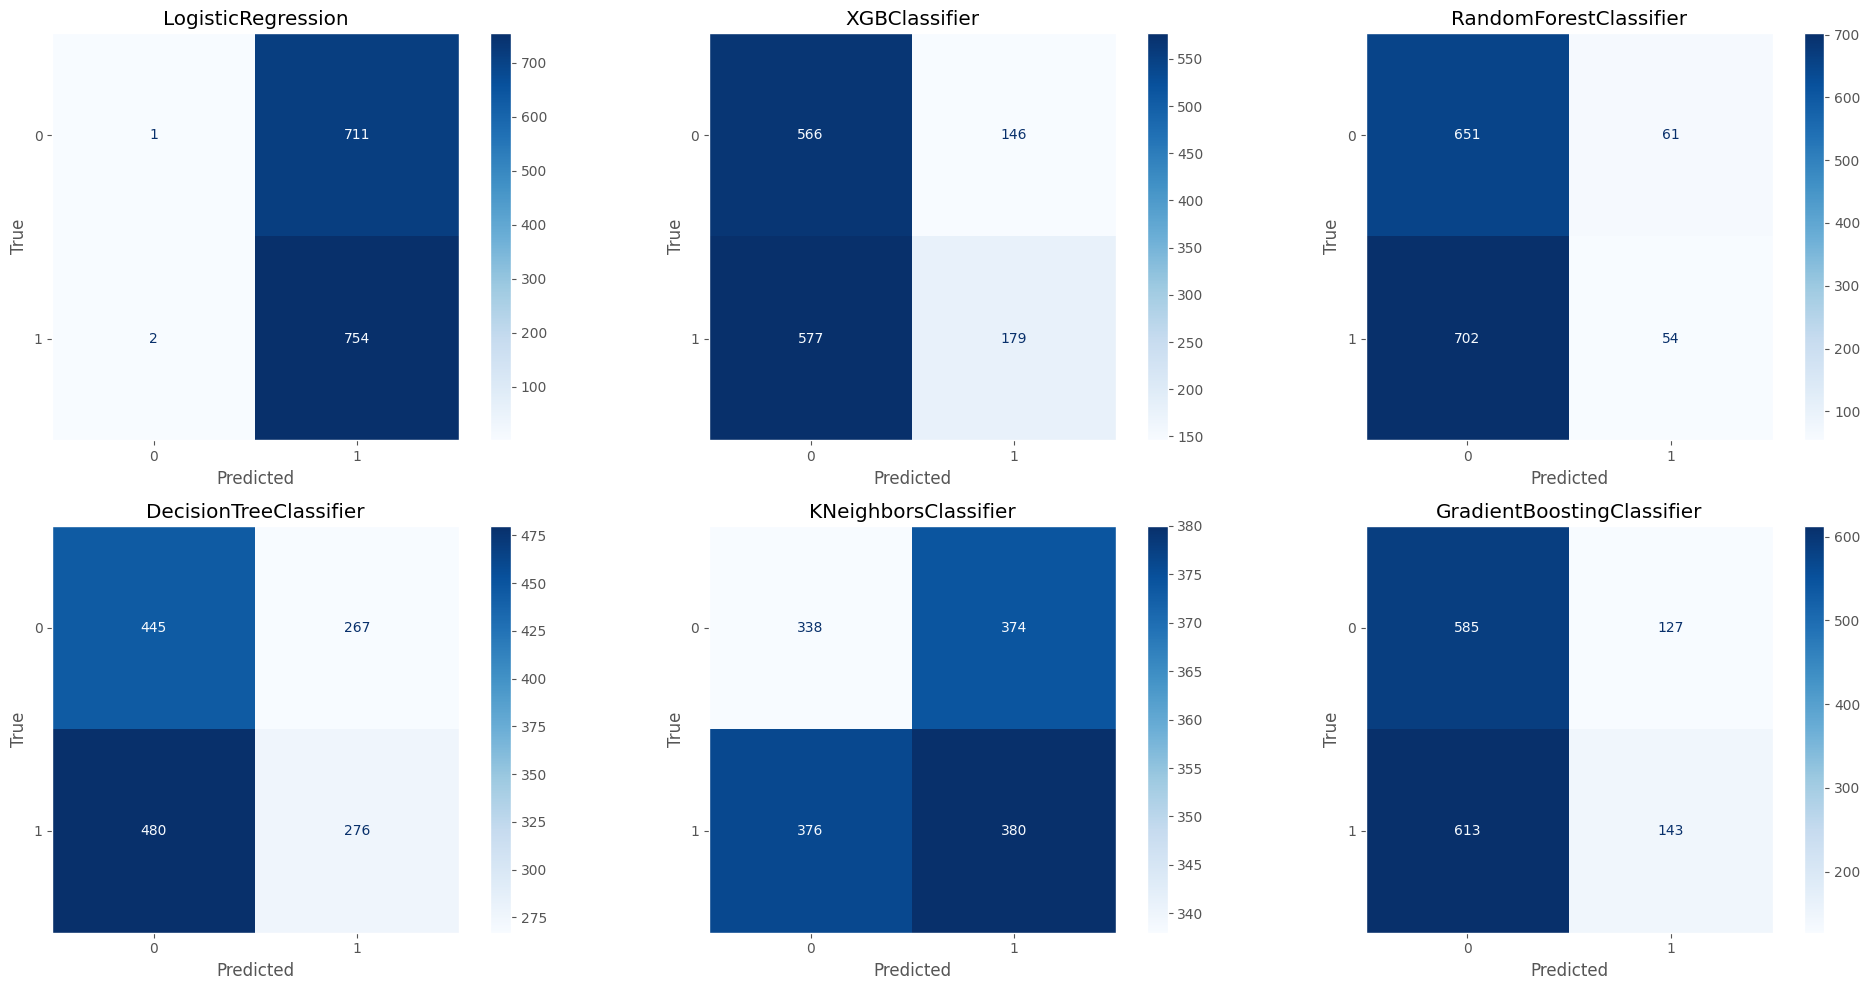

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Create a grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(20, 10))  # 2 rows and 4 columns (since you have 7 models, some axes will be empty)
axes = axes.ravel()  # Flatten the 2D array of axes for easy iteration

# Loop through all models and plot the confusion matrix for each
for i, model in enumerate(models):
    # Get the predicted classes
    y_pred = model.predict(X_test_cls)

    # Plot the confusion matrix on the corresponding subplot
    ConfusionMatrixDisplay.from_estimator(
        model, X_test_cls, y_test_cls, ax=axes[i], cmap='Blues', display_labels=model.classes_)

    axes[i].set_title(f'{model.__class__.__name__}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')
    axes[i].grid(False)

# Adjust layout for better readability
plt.tight_layout()
plt.show()


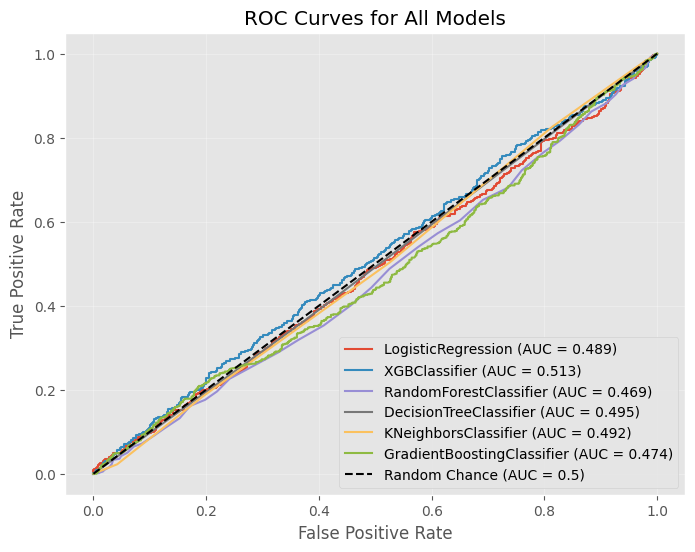

In [25]:
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt

# Create a figure for a single plot
plt.figure(figsize=(8, 6))

# Loop through all models and plot the ROC curve for each
for model in models:
    # Get predicted probabilities (not just 0/1 predictions)
    y_probs = model.predict_proba(X_test_cls)[:, 1]  # Probabilities for class 1

    # Calculate ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test_cls, y_probs)
    auc_score = roc_auc_score(y_test_cls, y_probs)

    # Plot ROC curve on the same plot
    plt.plot(fpr, tpr, label=f'{model.__class__.__name__} (AUC = {auc_score:.3f})')

# Plot random chance diagonal (AUC = 0.5)
plt.plot([0, 1], [0, 1], 'k--', label="Random Chance (AUC = 0.5)")

# Add labels and title
plt.title('ROC Curves for All Models')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Add legend
plt.legend(loc='lower right')

# Add grid
plt.grid(True, alpha=0.3)

# Show the plot
plt.show()



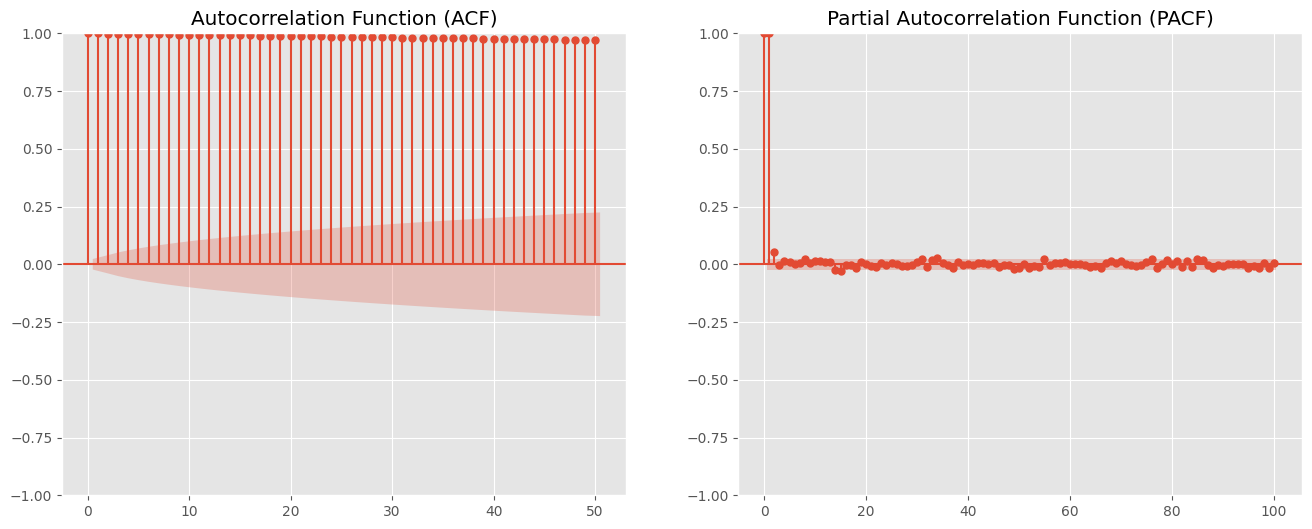

In [26]:
# --- PURE ARIMA MODEL (without pmdarima) ---
import warnings
warnings.filterwarnings('ignore')
# Install if needed
!pip install statsmodels --quiet

# Import libraries
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Prepare the series
series = df_raw['Close']
!pip install statsmodels --quiet

# Imports
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plot_acf(series, lags=50, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)')

plt.subplot(1,2,2)
plot_pacf(series, lags=100, ax=plt.gca(), method='ywm')
plt.title('Partial Autocorrelation Function (PACF)')

plt.show()

# Split into train/test
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

# --- Choose ARIMA order manually ---
# Common starting point: (p,d,q) = (5,1,0) or (2,1,2)
# You can tune these based on ACF/PACF plots if you want!


SARIMA RMSE: 241.46


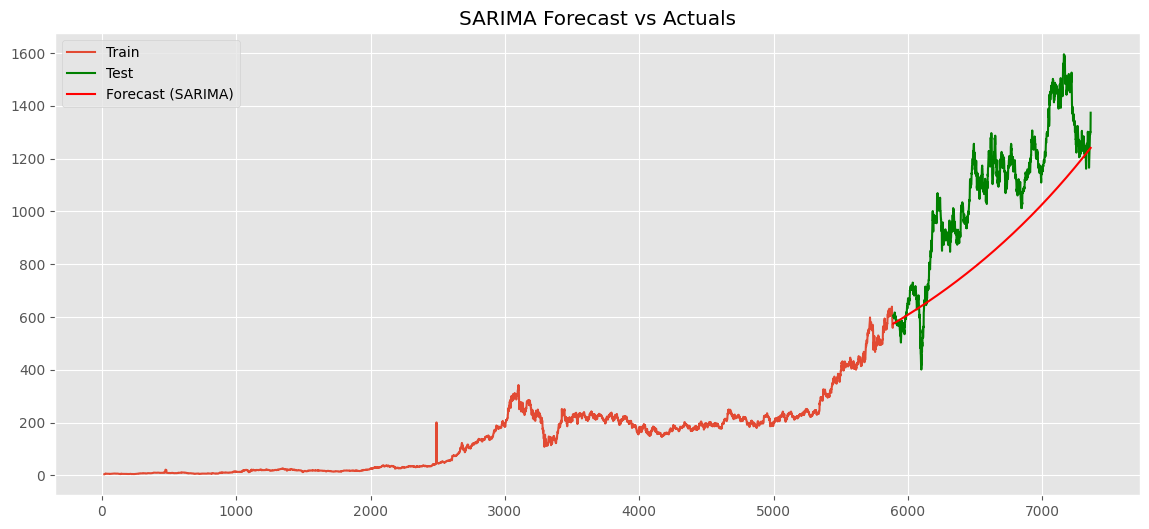

In [27]:
# Install if needed
!pip install statsmodels --quiet

# Import libraries
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
# Prepare the series
series = df_raw['Close']

# Split into train/test
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

# --- Set SARIMA orders ---
order = (1, 0, 1)
seasonal_order = (1, 0, 1, 24)      #seasonality is 24 that is 2 years

# --- Train SARIMA Model ---
sarima_model = SARIMAX(train,
                       order=order,
                       seasonal_order=seasonal_order,
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarima_result = sarima_model.fit()

# --- Forecast ---
n_periods = len(test)
forecast = sarima_result.forecast(steps=n_periods)

# --- Evaluate ---
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f'SARIMA RMSE: {rmse:.2f}')

# --- Plot ---
plt.figure(figsize=(14,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, color='green', label='Test')
plt.plot(test.index, forecast, color='red', label='Forecast (SARIMA)')
plt.title('SARIMA Forecast vs Actuals')
plt.legend()
plt.grid(True)
plt.show()


In [28]:
# --- Predict Today's Close Price using SARIMA ---
import warnings
warnings.filterwarnings('ignore')
# Fit on FULL dataset
full_sarima_model = SARIMAX(series,
                            order=order,
                            seasonal_order=seasonal_order,
                            enforce_stationarity=False,
                            enforce_invertibility=False)
full_sarima_result = full_sarima_model.fit()

# Forecast next step
today_forecast = full_sarima_result.forecast(steps=1)
predicted_today_close = today_forecast.values[0]

# Actual today close (from today's stored data)
actual_today_close = today_data['Close'].item()

# Accuracy
sarima_accuracy = (1 - abs(actual_today_close - predicted_today_close) / actual_today_close) * 100

print("Today's Close Prediction Results with SARIMA")
print(f"Predicted Close Value (SARIMA): {predicted_today_close:.2f}")
print(f"Actual Close Value: {actual_today_close:.2f}")
print(f"Prediction Accuracy: {sarima_accuracy:.2f}%")


Today's Close Prediction Results with SARIMA
Predicted Close Value (SARIMA): 1372.35
Actual Close Value: 1374.10
Prediction Accuracy: 99.87%
